# Temporal Difference Learning

* ***Bootstrap***: Learning without waiting for a final outcome. "Learning a guess from a guess" 

## TD Prediction

Policy evaluation in MC methods wat for the return. Every-visit MC for non-stationary environments

\begin{align}
V(S_t) \leftarrow V(S_t) + \alpha\left[ {\color{blue}G_t} - V(S_t) \right]
\end{align}

in contrast a simple TD method updates after every timestep

\begin{align}
V(S_t) \leftarrow V(S_t) + \alpha\left[ {\color{blue}R_{t+1} + \gamma V(S_{t+1})} - V(S_t) \right]
\end{align}

with the respective target in blue.
This is also called *TD(0)* or *one-step TD*.

With the the *TD error*

\begin{align}
\delta_t := R_{t+1} + \gamma V(S_{t+1}) - V(S_t
\end{align}

When $V$ is constant during a episode the *TD errors* can be written as 

\begin{align}
G_t - V(S_t) = \sum_{k=1}^{T-1} \gamma^{k-t} \delta_k
\end{align}


In [1]:
!pip install -r ../requirements.txt

In [2]:
import numpy as np
import dm_env
from tqdm import tqdm


def tabular_td0(environment: dm_env.Environment, policy: np.array, step_size: float = 0.1, number_of_episodes: int = 10, max_episode_length: int = 20,
                report_rate: int = 10, V: np.array = None, quite: bool = True, rng: np.random.RandomState = None) -> np.array:
    rng = rng or np.random.RandomState(1)
    # observation and state are the same
    specs = environment.observation_spec()
    state_count = specs.maximum - specs.minimum + 1

    if V is None:
        V = rng.uniform(0., 1., (state_count,))  # V[terminal] should be 0

    for episode_index in tqdm(range(number_of_episodes), desc='tabular TD(0)', disable=quite):
        state = rng.randint(specs.minimum, specs.maximum)
        environment.state = state
        for _ in range(max_episode_length):
            action = policy[state]
            step = environment.step(action)
            V[state] += step_size * \
                (step.reward + step.discount*V[step.observation] - V[state])
            state = step.observation
            if step.last():
                environment.reset()
                break

        if (episode_index + 1) % report_rate == 0:
            yield V


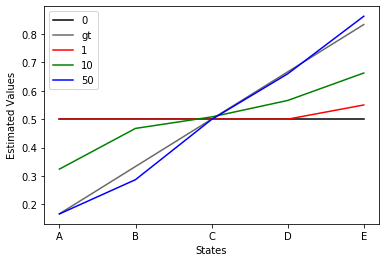

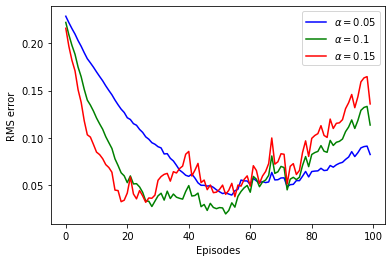

In [3]:
from dm_env import TimeStep, specs
import matplotlib.pyplot as plt


class RandomWalk(dm_env.Environment):
    def __init__(self, seed: int = 1) -> None:
        # states from 0 to 4
        #
        self._rng = np.random.RandomState(seed)
        self._reset()

    def reset(self) -> TimeStep:
        self._reset()
        return dm_env.restart(observation=self.state)

    def step(self, _) -> TimeStep:
        delta = self._rng.choice([-1, 1])
        self.state += delta

        if self.state < 0:
            return dm_env.termination(reward=0., observation=0)
        elif self.state > 4:
            return dm_env.termination(reward=1., observation=4)
        else:
            return dm_env.transition(reward=0., observation=self.state)

    def _reset(self):
        self.state = 2

    def observation_spec(self) -> specs.BoundedArray:
        return specs.BoundedArray(
            shape=(1,),
            dtype=int,
            name="position",
            minimum=0,
            maximum=4,
        )

    def action_spec(self) -> specs.DiscreteArray:
        return specs.BoundedArray(
            shape=(0,),
            dtype=int,
            name="no action",
            minimum=0,
            maximum=0,
        )


def random_walk_example():
    policy = np.zeros((5,), dtype=int)  # not needed here
    gt_value = np.asarray(range(1, 6)) / 6

    # change
    steps = {
        1: 'red',
        10: 'green',
        50: 'blue',
    }
    V = np.asarray([0.5]*5)
    plt.plot(V, color='black', label='0')
    plt.plot(gt_value, color='dimgrey', label='gt')
    env = RandomWalk()
    for i, value in enumerate(tabular_td0(environment=env, policy=policy, V=V, step_size=0.1, number_of_episodes=100, report_rate=1), 1):
        if i in steps:
            plt.plot(value, color=steps[i], label=f'{i}')
    plt.legend()
    plt.xticks(range(5), ['A', 'B', 'C', 'D', 'E'])
    plt.xlabel('States')
    plt.ylabel('Estimated Values')
    plt.show()

    # parameter sweep
    trials = {
        'blue': 0.05,
        'green': 0.1,
        'red': 0.15,
    }

    for color, step_size in trials.items():
        errors = []
        env = RandomWalk()
        V = np.asarray([0.5]*5)
        for value in tabular_td0(environment=env, policy=policy, V=V, step_size=step_size, number_of_episodes=100, report_rate=1):
            error = np.sqrt(np.mean((gt_value - value)**2))
            errors.append(error)

        plt.plot(errors, color=color, label=f'$\\alpha = {step_size:0.2}$')

    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('RMS error')
    plt.show()


random_walk_example()
